# Binary classification of car and tram audios 

## Introduction 

In this project a simple binary classifier model is built that classifies a 5 second recording to be either a recording of a car or a tram. Four features were analyzed from the audio samples: log-spectrograms, Mel-spectrograms, MFCCs, and delta-features (delta and delta-delta). The final
model was built by using MFCCs and delta-features, since they have a relatively low number of coefficients, 39 in total. The use of MFCC features seems to be appropriate, since by a short literature review, it seems like the features extracted by MFCC are successfully used in vehicle classification [1][2]. Also, the delta and delta-delta features of the MFCCs were added to the data before classification to enhance the classification.

In [1]:
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

In [2]:
# Global variables
SR = 16000
random_state = 42

## Data loading and normalization

The data consists of recordings of car and tram sounds. The data comes from Freesound where me and other students have published their recordings. It is only assumed that all the audio files contain what is stated in the file title (i.e. car or tram), and that they don’t contain speech, since all the files weren’t manually checked. The training data contains audio samples from various Freesound users, while the validation and testing data contains audio samples from individual users.

In order to compare the samples more easily, the audio files are cut to exactly 5 seconds. Also, the files that are under 5 seconds were removed. A sampling frequency of 16 kHz was used to sample every audio file. This way every sample has the same number of values. 

In [3]:
# Function to normalize signal by its maximum value.
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

In [4]:
# Function to download audio files from the folder.
# Signals are normalized to have values [0, 1].
# Signals are also normalized to be the same length.
def download_audio(audio_dir):
    audio_samples = []

    audio_files = [f for f in os.listdir(audio_dir) if f.endswith(".wav")]
    print(
        f"Number of audio files originally in {audio_dir}: {len(audio_files)}")

    for audio_file in audio_files:
        file_path = os.path.join(audio_dir, audio_file)
        y, sr = librosa.load(file_path, sr=SR, duration=5)

        duration = librosa.get_duration(y=y, sr=sr)
        if duration >= 5:
            audio_samples.append(normalize_audio(y))

    print(
        f"Number of 5 second audio files in {audio_dir}: {len(audio_samples)}")
    print()

    return audio_samples

In [5]:
try:
    car_train_directory = r"cars\train"
    car_validation_directory = r"cars\validation"
    car_test_directory = r"cars\test"

    tram_train_directory = r"trams\train"
    tram_validation_directory = r"trams\validation"
    tram_test_directory = r"trams\test"

    car_train = download_audio(car_train_directory)
    car_validation = download_audio(car_validation_directory)
    car_test = download_audio(car_test_directory)

    tram_train = download_audio(tram_train_directory)
    tram_validation = download_audio(tram_validation_directory)
    tram_test = download_audio(tram_test_directory)

except OSError as e:
    print(e)
    print("Couldn't find necessary data folders.")

Number of audio files originally in cars\train: 750
Number of 5 second audio files in cars\train: 636

Number of audio files originally in cars\validation: 32
Number of 5 second audio files in cars\validation: 32

Number of audio files originally in cars\test: 21
Number of 5 second audio files in cars\test: 21

Number of audio files originally in trams\train: 588
Number of 5 second audio files in trams\train: 569

Number of audio files originally in trams\validation: 31
Number of 5 second audio files in trams\validation: 30

Number of audio files originally in trams\test: 20
Number of 5 second audio files in trams\test: 20



After the cleaning the training data has 636 car samples and 569 tram samples, the validation data have 32 car samples and 30 tram samples, and the testing data have 21 car samples and 20 tram samples.

## Feature extraction

First, the power spectrograms are inspected. Power spectrogram is relatively easy to calculate, and its interpretation is quite simple: plot the amplitudes of the heard frequencies for each time index. I wanted to see if there’s a clear distinction between the classes with just a simple spectrogram. Four samples of each class are selected from the training data at four different indices.

In [6]:
# Function to print power spectrograms of four class samples.
def print_spectrogram(four_samples, class_label, index_list):
    fig, axs = plt.subplots(nrows=2, ncols=2)
    axs = axs.flatten()

    for i, ax in enumerate(axs):
        D = librosa.amplitude_to_db(
            np.abs(librosa.stft(four_samples[i])), ref=np.max)
        img = librosa.display.specshow(D, y_axis='log', x_axis='time',
                                       sr=SR, ax=ax)

        ax.set(title=f"{class_label} sample {index_list[i]}")
        ax.label_outer()

    plt.suptitle(f"Log-frequency power spectrograms of {class_label}s")
    fig.colorbar(img, ax=axs, format="%+2.f dB")
    plt.show()

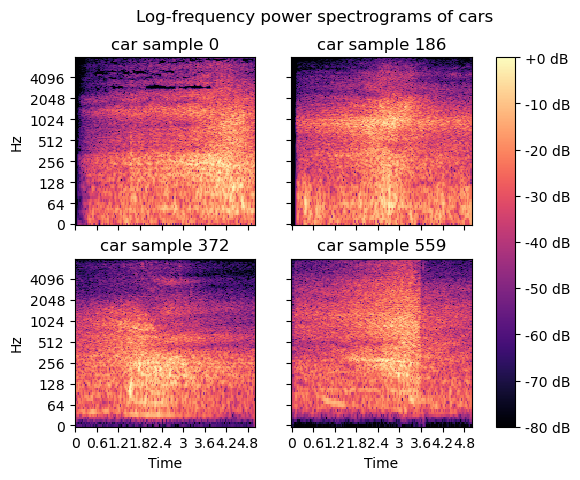

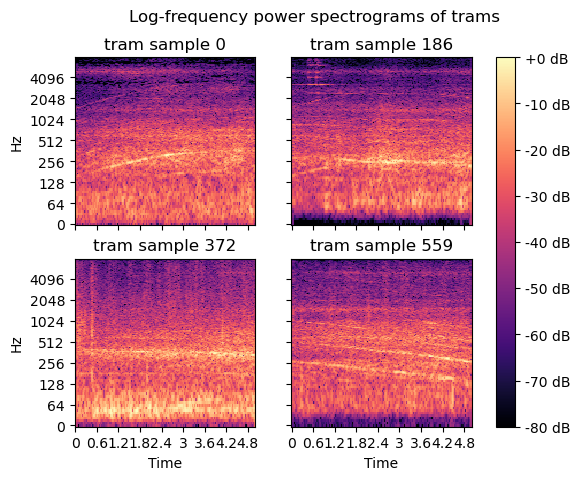

In [7]:
# Select 4 samples based on the size of the smaller class
index_list = (np.linspace(0, min(len(car_train), len(tram_train)) - 10,
                          num=4)).astype(int)
car_samples_4 = [car_train[i] for i in index_list]
tram_samples_4 = [tram_train[i] for i in index_list]

# Spectrograms
print_spectrogram(car_samples_4, "car", index_list)
print_spectrogram(tram_samples_4, "tram", index_list)

There are some differences between the spectrograms of the two classes. There seems to be more defined horizontal lines in the spectrograms of tram sample. These represent certain frequencies that are continuous in time.

Then, the Mel-spectrograms are inspected. Human hearing has better frequency resolution at lower frequencies, and Mel-spectrogram mimics that. In a way, it gives more emphasis on lower frequencies. The same four samples are used with each class as in figure 1.

In [8]:
# Function to print Mel spectrograms of four class samples.
def print_mel_spectrogram(four_samples, class_label, index_list, n_mels=40):
    fig, axs = plt.subplots(nrows=2, ncols=2)
    axs = axs.flatten()

    for i, ax in enumerate(axs):
        M = librosa.feature.melspectrogram(y=four_samples[i], n_mels=n_mels,
                                           sr=SR)
        M_db = librosa.power_to_db(M, ref=np.max)
        img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time',
                                       ax=ax, sr=SR)
        ax.set(title=f"{class_label} sample {index_list[i]}")
        ax.label_outer()

    plt.suptitle(f"Mel spectrograms of {class_label}s")
    fig.colorbar(img, ax=axs, format="%+2.f dB")
    plt.show()

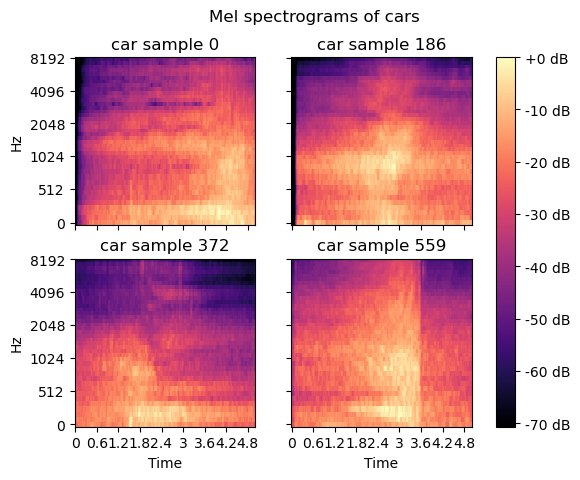

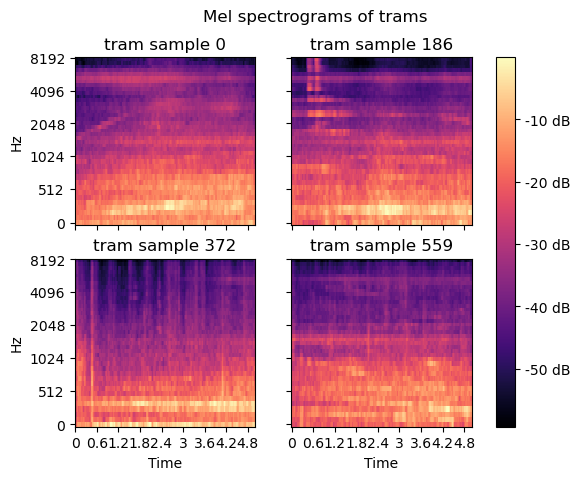

In [9]:
# Mel spectrograms
print_mel_spectrogram(car_samples_4, "car", index_list, n_mels=40)
print_mel_spectrogram(tram_samples_4, "tram", index_list, n_mels=40)

The Mel spectrograms look similar to the power spectrograms that were plotted earlier. However, now the differences between the classes are more pronounced. It can be seen that the tram sample 0 resembles a tram leaving the station (accelerating) and tram sample 559 resembles a tram that is coming to the station (stopping).

The number of mel bands used was 40. In order to still remove redundant information, the MFCC features are calculated. Now the information is contained in just 13 coefficients and each coefficient is uncorrelated with other coefficients. Finally, the MFCCs are calculated for every sample in the training data and the coefficients are then averaged for each class. The
results are displayed below.


In [10]:
# Function to calculate the average of the MFCCs and delta-features (delta
# and delta-delta) of the given signal.
def calc_avg_mfcc_features(s, n_mfcc):
    mfccs = librosa.feature.mfcc(y=s, n_mfcc=n_mfcc, sr=SR)
    delta = librosa.feature.delta(mfccs)
    delta2 = librosa.feature.delta(mfccs, order=2)

    features = np.concatenate((mfccs, delta, delta2), axis=0)
    avg_features = np.mean(features, axis=1)

    return avg_features

In [11]:
# Function to call calc_avg_mfcc_features to the samples
# from a list of samples.
def calc_mfcc_features(data, n_mfcc):
    avg_features = []

    for sample in data:
        avg_sample_features = calc_avg_mfcc_features(sample, n_mfcc)
        avg_features.append(avg_sample_features)

    return avg_features

In [12]:
# Function to print average MFCCs for each class.
def print_avg_class_mfccs(class_features_list, n_mfcc):
    avg_mfccs = [np.mean(np.array(class_features)[:, :n_mfcc], axis=0)
                 for class_features in class_features_list]

    print("Averaged MFCCs for training data:")
    for mfcc_class in avg_mfccs:
        print([np.round(val, 1) for val in mfcc_class])
    print()

In [13]:
# MFCC and delta-features
n_mfcc = 13

car_features_train = calc_mfcc_features(car_train, n_mfcc)
tram_features_train = calc_mfcc_features(tram_train, n_mfcc)
features_train = [car_features_train, tram_features_train]

print_avg_class_mfccs(features_train, n_mfcc)

Averaged MFCCs for training data:
[-71.4, 106.8, -19.1, 14.0, 3.0, 14.7, 1.4, 8.6, -2.8, 2.0, -6.1, 0.8, -5.8]
[-88.6, 132.5, 1.8, 15.4, -6.9, 13.0, -15.8, 4.6, -9.6, 5.0, -7.9, -8.5, -0.1]



There seems to be some differences between the averaged coefficients between the classes. Especially the coefficients 3, 5, 7, and 12 have opposing signs. This indicates that there seems to be discrimination power with the MFCCs.

MFCCs are often used in recognition tasks with speech signals, and since speech signal is temporary and changes a lot, usually features about the transitions are also used. Transition features include delta and delta-delta methods, which can be interpreted as first and second derivatives of the signal. [3] They will also be used when building the model.

## Data split

The data is split into training, validation, and testing data. Training data consists of 636 car samples and 569 tram samples, testing data consists of 21 car samples and 20 tram samples, and validation data consists of 32 car samples and 30 tram samples, as was stated earlier.

In [14]:
# Function to combine feature lists of both classes to form
# training, validation and testing data.
def concat_data(class_features_list):
    car_features = class_features_list[0]
    tram_features = class_features_list[1]
    x = np.concatenate((car_features, tram_features), axis=0)
    y = list(np.zeros(len(car_features))) + list(np.ones(len(tram_features)))

    return x, y

In [15]:
car_features_valid = calc_mfcc_features(car_validation, n_mfcc)
tram_features_valid = calc_mfcc_features(tram_validation, n_mfcc)
features_valid = [car_features_valid, tram_features_valid]

car_features_test = calc_mfcc_features(car_test, n_mfcc)
tram_features_test = calc_mfcc_features(tram_test, n_mfcc)
features_test = [car_features_test, tram_features_test]

# Data split
x_train, y_train = concat_data(features_train)
x_valid, y_valid = concat_data(features_valid)
x_test, y_test = concat_data(features_test)

The data contains averaged MFCCs and delta-features (delta and delta-delta) of each sample. This means that every sample is being averaged across time, so each sample becomes a (1, 39) vector. Let’s visualize the discrimination between the classes based on these features by plotting a t-SNE scatter plot.

In [16]:
# Function to plot t-SNE scatter plot to 2 classes.
def plot_2class_tsne(x, change_ind, random_state=42):
    X_embedded = TSNE(n_components=2, learning_rate='auto', init='random',
                      perplexity=3, random_state=random_state).fit_transform(x)

    plt.scatter(X_embedded[:change_ind, 0], X_embedded[:change_ind, 1],
                label="car")
    plt.scatter(X_embedded[change_ind:, 0], X_embedded[change_ind:, 1],
                label="tram")
    plt.xlabel("component 1")
    plt.ylabel("component 2")
    plt.legend()
    plt.title("t-SNE scatter plot")
    plt.show()

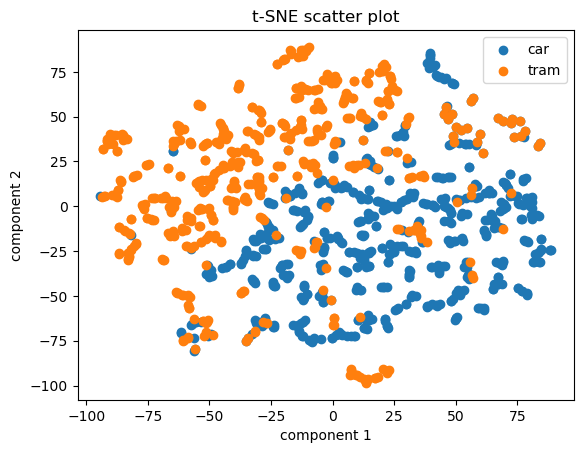

In [17]:
# t-SNE plot
change_ind = len(car_features_train)
plot_2class_tsne(x_train, change_ind)

The classes seem to have discrimination with the selected features. It’s time to build a model that can find this discrimination.

## Model selection 

The model was built by using logistic regression, which is a relatively simple binary classifier. The model is first fitted by using the training data, and then evaluated by using validation data.

In [18]:
# Function to print accuracy, precision and recall from predicted values.
# Data label indicates if validation data or testing data is used.
def calc_metrics(preds, y_true, data_label):
    accuracy = sum(preds == y_true) / len(y_true)
    precision = sum((preds == y_true)[preds == 1]) / len(
        preds[preds == 1])
    recall = sum((preds == y_true)[preds == 1]) / len(
        y_true[y_true == 1])

    print(f"{data_label} accuracy for the model: {np.round(accuracy, 2)}")
    print(
        f"{data_label} precision for the model: {np.round(precision, 2)}")
    print(f"{data_label} recall for the model: {np.round(recall, 2)}")
    print()

In [19]:
# Shuffle data for better model performance
x_train, y_train = shuffle(x_train, y_train, random_state=random_state)
x_valid, y_valid = shuffle(x_valid, y_valid, random_state=random_state)
x_test, y_test = shuffle(x_test, y_test, random_state=random_state)

# Scale data
min_max_scaler = MinMaxScaler()
x_train_scaled = min_max_scaler.fit_transform(x_train)
x_valid_scaled = min_max_scaler.fit_transform(x_valid)
x_test_scaled = min_max_scaler.fit_transform(x_test)

y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

# Fit model
model = linear_model.LogisticRegression(penalty=None)
model.fit(x_train_scaled, y_train)

# Evaluation
valid_preds = model.predict(x_valid_scaled)
calc_metrics(valid_preds, y_valid, "validation")

validation accuracy for the model: 1.0
validation precision for the model: 1.0
validation recall for the model: 1.0



The model gives perfect discrimination results with the validation data. Since the model seem to separate the classes perfectly, the current model is selected without any tuning.

## Results

With the testing set, the model gives the following results.

In [20]:
# Results
test_preds = model.predict(x_test_scaled)
calc_metrics(test_preds, y_test, "test")

test accuracy for the model: 0.76
test precision for the model: 0.67
test recall for the model: 1.0



The accuracy, precision and recall are quite good with testing set. Let’s visualize the discriminations with a confusion matrix.

In [21]:
# Function to print confusion matrix based on the predictions.
def plot_confusion_matrix(preds, y_true):
    cm = confusion_matrix(y_true, preds)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['car', 'tram'])
    cmd.plot()
    cmd.ax_.set(xlabel='Predicted', ylabel='True', title="Confusion matrix")
    plt.show()

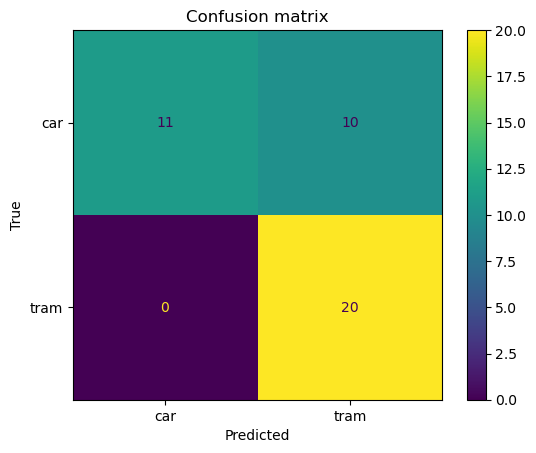

In [22]:
plot_confusion_matrix(test_preds, y_test)

The model falsely classifies almost half of the cars incorrectly as tram. However, the model correctly classifies all the trams.

## Conculsion 

The model seems to classify the files with okay accuracy overall, but it has trouble classifying cars. I don’t really know what causes this. But based on the inspected features, some discrimination was expected, since the features seemed to have differences between the classes.

The data splitting could have been done in a way that the training, validation and test data would have been randomly selected from the whole dataset, instead of using the recordings of separate users as the validation and test data. I think there might be a possibility of bias in the validation and test data, since the recordings might be similar to each other since they are from one person only. Also, the validation and test dataset could have been larger. Also, the split between validation and test data might be unnecessary since there wasn’t any tuning of the model based on the model evaluation with the validation data.

Delta-features amplify the noise of the signal (and I’m sure there’s a lot of it in the data), and they are still a linear transform of the input features. [3] Also, since the signals of vehicle recordings can be seen to be more stationary than speech signal, the delta-features might not
add valuable information to the model.

## References

[1] George J, Cyril A, I. Koshy B, Mary L. Exploring Sound Signature for Vehicle Detection and Classification Using ANN. International journal on soft computing. 2013;4(2):29–36.

[2] Kangyan Wang, Rui Wang, Yutian Feng, Haiyan Zhang, Qunfeng Huang, Yanliang Jin, et al. Vehicle recognition in acoustic sensor networks via sparse representation. In: 2014 IEEE International Conference on Multimedia and Expo Workshops (ICMEW). IEEE; 2014. p. 1–4.

[3] Bäckström T. Deltas and Delta-deltas. Aalto University Wiki, [updated 2019, cited 12.12.2023]. Available from: https://wiki.aalto.fi/display/ITSP/Deltas+and+Delta-deltas.